### Đệm và sải bước
- Trong ví dụ trước, đầu vào có cả chiều dài và chiều rộng bằng 3, cứa số hạt nhân tích chập có cả chiều dài và chiều rộng bằng 2, nên ta thu được biểu diễn đầu ra có kích thước 2x2. Nói chung, giả sử kích thước của đầu vào là n_h x n_w và kích thước của hạt nhân tích chập là k_h x k_w thì kích thước của đầu ra sẽ là:
    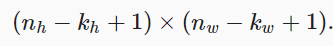
- Do đó, kích thước của đầu ra tầng tích chập được xác định bởi kích thước đầu vào các kích thước của cửa sổ hạt nhân tích chập
- Trong vài trường hợp, ta sẽ két hợp thêm các kỹ thuật khác có ảnh hưởng tới kích thước của đầu ra, như thêm phần đệm và phép tích chập sải bước. 
- Lưu ý rằng vì các hạt nhân thường có chiều rộng và chiều cao lớn hơn 1 nên sau khi áp dụng nhiều phép tích chập liên tiếp, đầu ra thường có kích thước nhỏ hơn đáng kể so với đầu vào. 
- Ví dụ: nếu bắt đầu với một ảnh có 240 x 240 điểm ảnh và áp dụng 10 tầng tích chập có kích thước 5 x 5 thì kích thước của ảnh này sẽ giảm xuống 200 x 200 điểm ảnh, 30% của ảnh đã bị cắt bỏ và __mọi thông tin trên VIỀN của ảnh gốc sẽ bị xóa sạch. Đệm là công cụ phổ biến nhất để giải quyết vấn đề này.__
- Trong những trường hợp khác, ta có thể sẽ muốn giảm đáng kể kích thước ảnh, ví dụ như khi độ phân giải của đầu vào quá cao. __Phép tích chập sải bước (strided convolution) là một kỹ thuật phổ biến có thể giúp ích trong trường hợp này.__
#### 1. Đệm
- Như mô tả ở trên, một vấn đề rắc rối khi áp dụng các tầng tích chập là việc chúng ta có thể mất một số điểm ảnh trên biên của ảnh. Vì ta thường chỉ sử dụng các hạt nhân nhỏ, với một phép tích chập ta có thể chỉ mất một ít điểm ảnh. Tuy nhiên sự mất mát này có thể tích lũy dần khi ta thực hiện qua nhiều tầng tích chập liên tiếp. Một giải pháp đơn giản cho vấn đề này là chèn thêm các điểm ảnh xung quanh đường biên trên bức ảnh đầu vào, nhờ đó làm tăng kích thước sử dụng của bức ảnh.
- Thông thường, ta thiết lập cá giá trị của điểm ảnh thêm vào là 0. 

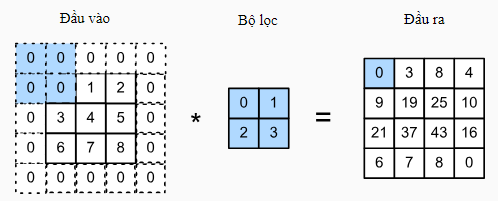

- Các mạng nơ ron tích chập thường sử dụng các hạt nhân tích chập với chiều dài và chiều rộng là số lẻ như 1, 3, 5, 7. Việc chọn hạt nhân có kích thước lẻ giúp ta bảo toán được các chiều không gian khi thêm cùng số hàng đệm cho cạnh trên và dưới và thêm cùng số cột đệm cho cạnh trái và phải.
- Hơn nữa, việc sử dụng bộ kích thước lẻ sẽ giúp ta chắc chắn rằng phần tử đầu ra Y[i, j] sẽ được tính bằng phép tương quan chéo giữa đầu vào và hạt nhân tích chập có tâm nằm tại X[i, j]

In [ ]:
# Nhắc lại kiến thức cộng tuple
(1, 1) + (3, 3)

(1, 1, 3, 3)

In [6]:
from mxnet import np, npx
from mxnet.gluon import nn
npx.set_np()

# We define a function to calculate the convolutional layer.
# This function initialize the convolutional layer weights and performs
# corresponding dimensionality evaluations and reductions the input and output
def comp_conv2d(conv2d, X):
    conv2d.initialize()
    # (1, 1) indicates that the batch_size and the number of channels are both 1
    X_shape = X.shape
    X = X.reshape((1, 1) + X.shape)
    Y = conv2d(X)

    # Exclude the first two dimensions that do not interest us: batch_size and channel
    return Y.reshape(X_shape)

# If padding is non-zero, then the input is implicitly zero-padded on both sides for
# padding number of points
conv2d = nn.Conv2D(1, kernel_size=3, padding = 1)
X = np.random.uniform(size = (8, 8))
comp_conv2d(conv2d, X).shape

(8, 8)

- Khi chiều dài và chiều rộng của hạt nhân tích chập khác nhau, ta có thể điều chỉnh chiều dài và chiều rộng khác nhau cho phần đện để đầu vào và đầu ra có cùng kích thước.

In [ ]:
conv2d = nn.Conv2D(1, kernel_size=(5, 3), padding = (2, 1))
comp_conv2d(conv2d, X).shape

(8, 8)

#### 2. Sải bước
- Khi thực hiện phép tương quan chéo, ta bắt đầu với cửa số tích chập tại góc trên bên trái của mảng đầu vào, rồi di chuyển sang phải và xuống dưới qua tất cả các vị trí. Trong các ví dụ trước, ta mặc định di chuyển qua mỗi điểm ảnh một lần.  Tuy nhiên, có những lúc để tăng hiệu suất tính toán hoặc vì muốn giảm kích thước của ảnh, ta di chuyển cửa số tích chập nhiều hơn một điểm ảnh mỗi lần, bỏ qua các vị trí ở giữa.
- Ta gọi số hàng và cột di chuyển qua mỗi lần là sải bước (stride). Cho đến giờ, ta sử dụng sải bước 1 cho cả chiều dài và chiều rộng. Đôi lúc, ta có thể muốn sử dụng sải bước lớn hơn. Ví dụ ở dưỡi miêu tả ví dụ tương quan chéo hai chiều với sải bước 3 theo chiều dọc và 2 theo chiều ngang.

    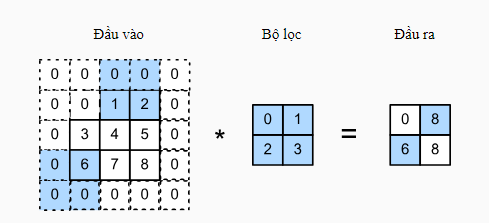

- Nhìn chung, khi sải bước theo chiều cao là s_h và sải bước theo chiều rộng là s_w, kích thước đầu ra là:

    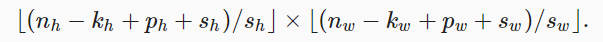

    